In [27]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers
# to split dataset
from sklearn.model_selection import train_test_split
# to import dataset
from sklearn.datasets import fetch_lfw_people
%matplotlib inline
from tensorflow.keras.preprocessing import image_dataset_from_directory
import os

In [28]:
# Cell used to truncate the dataset with respect to a minimum number of files per person
import shutil
import os
path = "./data/lfw_12/"
my_list = os.listdir(path)
for folder in my_list:
    list_of_files = os.listdir(path+folder)
    if len(list_of_files) < 50:
        shutil.rmtree(path + folder)
my_list = os.listdir(path)

In [29]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
# data_git for when on macbook
directory = "../OTHERS/data/lfw_12/"
train_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='training',
                                             seed = 42)
                                            #  seed = 42
validation_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='validation',
                                             seed = 42)
                                            #  seed = 42

Found 1560 files belonging to 12 classes.
Using 1248 files for training.
Found 1560 files belonging to 12 classes.
Using 312 files for validation.


In [30]:
classes = 5749

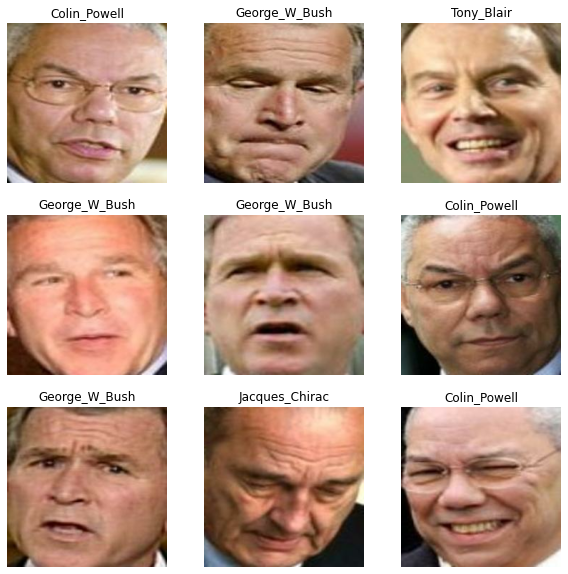

In [31]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [32]:
def data_augmenter():
    '''
    Create a Sequential model composed of 2 layers
    Returns:
        tf.keras.Sequential
    '''
    ### START CODE HERE
    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(layers.experimental.preprocessing.RandomFlip('horizontal'))
    data_augmentation.add(layers.experimental.preprocessing.RandomRotation(0.2))
    ### END CODE HERE
    
    return data_augmentation

In [33]:
preprocess_input = tf.keras.applications.resnet_v2.preprocess_input

In [34]:
IMG_SHAPE = IMG_SIZE + (3,)
print(IMG_SHAPE, IMG_SIZE)
base_model = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE,
                                               include_top=True,
                                               weights='imagenet')

(224, 224, 3) (224, 224)


In [35]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_4[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [36]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 1000)


In [37]:
#Shows the different label probabilities in one tensor 
label_batch

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([ 5,  3,  2,  2,  3,  3,  3,  6,  3,  2,  7,  5,  3,  9, 11, 11, 11,
        2,  3,  3,  3, 11,  9,  3, 11,  3,  0,  4,  8,  4, 11,  3])>

In [38]:
# base_model.trainable = False
# image_var = tf.Variable(preprocess_input(image_batch))
# pred = base_model(image_var)

# tf.keras.applications.mobilenet_v2.decode_predictions(pred.numpy(), top=2)

In [39]:
def celeb_model(image_shape=IMG_SIZE,  data_augmentation=data_augmenter()):
    ''' Defines a tf.keras model for multiclass classification out of the MobileNetV2 model
    Arguments:
        image_shape -- Image width and height
        data_augmentation -- data augmentation function
    Returns:
        tf.keras.model
    '''
    
    
    input_shape = image_shape + (3,)
    
    ### START CODE HERE
    
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                                   include_top=False, # <== Important!!!!
                                                   weights='imagenet') # From imageNet

    # freeze the base model by making it non trainable
    base_model.trainable = False


    # create the input layer (Same as the imageNetv2 input size)
    inputs = tf.keras.Input(shape=input_shape) 
    
    # apply data augmentation to the inputs
    # x = data_augmentation(inputs)
    
    # data preprocessing using the same weights the model was trained on
    x = preprocess_input(inputs) 
    
    # set training to False to avoid keeping track of statistics in the batch norm layer
    x = base_model(x, training=False) 

    # use global avg pooling to summarize the info in each channel
    x = layers.GlobalAveragePooling2D()(x) 
    # include dropout with probability of 0.2 to avoid overfitting
    x = layers.Dropout(0.2)(x)

    # x = layers.Dense(32, activation = "relu")(x)
    # # x = layers.Dropout(0.2)(x)
    # x = layers.Dense(16, activation = "relu")(x)
    # # x = layers.Dropout(0.2)(x)

    # use a prediction layer
    out = layers.Dense(12, name='classifier', activation = "softmax")(x)
    
    model = tf.keras.Model(inputs, out)
    
    return model

In [40]:
model2 = celeb_model()

In [41]:
base_learning_rate = 0.001
optimizer = keras.optimizers.SGD(momentum=0.01)
model2.compile(optimizer="adam",
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits = False),
              metrics=['accuracy'])

In [42]:
initial_epochs = 5
history = model2.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs)

Epoch 1/5
39/39 [==============================] - 14s 328ms/step - loss: 2.1401 - accuracy: 0.3413 - val_loss: 1.7108 - val_accuracy: 0.4904
Epoch 2/5
39/39 [==============================] - 12s 306ms/step - loss: 1.5185 - accuracy: 0.5401 - val_loss: 1.3633 - val_accuracy: 0.5705
Epoch 3/5
39/39 [==============================] - 12s 306ms/step - loss: 1.1947 - accuracy: 0.6538 - val_loss: 1.1343 - val_accuracy: 0.6795
Epoch 4/5
39/39 [==============================] - 12s 305ms/step - loss: 0.9856 - accuracy: 0.7188 - val_loss: 1.0145 - val_accuracy: 0.7212
Epoch 5/5
39/39 [==============================] - 12s 306ms/step - loss: 0.8437 - accuracy: 0.7708 - val_loss: 0.9459 - val_accuracy: 0.7340


In [43]:
# class_names

In [44]:
# UNQ_C3
base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 120


# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
    
# Define a MulitClass loss function. from_logits=False as we already have softmax
loss_function=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
# Define an Adam optimizer with a learning rate of 0.1 * base_learning_rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.1*base_learning_rate)

# Use accuracy as evaluation metric
metrics=['accuracy']

model2.compile(loss=loss_function,
              optimizer = "adam", 
              metrics=metrics)

Number of layers in the base model:  177


In [45]:
fine_tune_epochs = 35
total_epochs =  initial_epochs + fine_tune_epochs
 
history_fine = model2.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=initial_epochs,
                         validation_data=validation_dataset)

Epoch 6/40
39/39 [==============================] - 14s 319ms/step - loss: 0.7912 - accuracy: 0.7700 - val_loss: 0.8558 - val_accuracy: 0.7404
Epoch 7/40
39/39 [==============================] - 12s 308ms/step - loss: 0.6437 - accuracy: 0.8341 - val_loss: 0.8007 - val_accuracy: 0.7692
Epoch 8/40
39/39 [==============================] - 12s 308ms/step - loss: 0.5770 - accuracy: 0.8558 - val_loss: 0.7549 - val_accuracy: 0.8045
Epoch 9/40
39/39 [==============================] - 12s 308ms/step - loss: 0.5207 - accuracy: 0.8742 - val_loss: 0.7265 - val_accuracy: 0.8013
Epoch 10/40
39/39 [==============================] - 12s 309ms/step - loss: 0.4735 - accuracy: 0.8838 - val_loss: 0.6990 - val_accuracy: 0.8301
Epoch 11/40
39/39 [==============================] - 12s 309ms/step - loss: 0.4273 - accuracy: 0.8998 - val_loss: 0.6851 - val_accuracy: 0.8141
Epoch 12/40
39/39 [==============================] - 12s 309ms/step - loss: 0.3864 - accuracy: 0.9223 - val_loss: 0.6470 - val_accuracy: 0.8

In [46]:
print(model2.evaluate(train_dataset))
print(model2.evaluate(validation_dataset))

39/39 [==============================] - 10s 259ms/step - loss: 0.0627 - accuracy: 0.9976
[0.06269293278455734, 0.9975961446762085]
10/10 [==============================] - 3s 250ms/step - loss: 0.5652 - accuracy: 0.8462
[0.5652438998222351, 0.8461538553237915]


In [47]:
model2.save("models/RNv2_12C")

INFO:tensorflow:Assets written to: models/RNv2_12C\assets


INFO:tensorflow:Assets written to: models/RNv2_12C\assets
